In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from scipy.stats import randint

**Insights from the Data:**



**1. Strength Distribution:** The distribution of password strength in the dataset shows that it's not normally distributed. It appears to be skewed, with a noticeable concentration towards certain strength levels.



**2. Password Length:** Password lengths vary widely, with a range from 4 to 63 characters. The distribution suggests that shorter passwords are more common, but there are also longer passwords present.



**3. Password Complexity Metrics:**



- **Entropy and Password Strength:** There is a strong positive correlation between password entropy and password strength. Stronger passwords tend to have higher entropy values.



- **Character Types:** The number of uppercase letters, lowercase letters, numbers, and special characters varies across passwords. Analyzing their distributions reveals patterns in password complexity.



**4. Crack Time vs. Strength:** There is a strong positive correlation between password strength and the estimated crack time ('crack_time_sec'). Stronger passwords are associated with longer crack times, indicating improved security.



**5. Categorical 'crack_time':** The categorical variable 'crack_time' appears to have a good relationship with password strength. Certain categories might represent different password policies or security levels.





**6. Duplicate Passwords:** A significant number of duplicate passwords (75011 duplicates) are present in the dataset.





**7. Feature Engineering:** Derived features such as 'strength_points,' 'num_numbers,' 'num_special_characters,' 'num_uppercase,' 'num_lowercase,' and 'crack_time_category' have been created to capture password complexity and crack time categories.



**8. Data Types:** The dataset comprises float64, int64, and object data types. Proper data type handling and encoding may be necessary for model development.



**9. Correlations:** The correlation matrix reveals strong positive correlations between 'strength' and various password complexity metrics. These correlations can be leveraged for predictive modeling.



**10. Outliers:** Several outliers are present in the dataset, particularly in the 'crack_time_sec' and 'num_special_characters' columns.

In [4]:
df_1 = pd.read_csv('/content/passwords1.csv')
pd.options.display.float_format = '{:.10f}'.format
df_1

,password,strength,length,entropy,crack_time_sec,crack_time
0,bybee,0.0880534720,5,11.6096404700,0.0000015600,instant
1,n3m0,0.0888888890,4,8.0000000000,0.0000001280,instant
2,2509,0.0888888890,4,8.0000000000,0.0000001280,instant
3,4622,0.0704427780,4,8.0000000000,0.0000001280,instant
4,shrk,0.0888888890,4,8.0000000000,0.0000001280,instant
...,...,...,...,...,...,...
99995,sifelizestasdecirmeloquerras,0.9321498090,28,134.6059378000,16599999999999999035299879452672.0000000000,Eternity
99996,iwillalwayslovemyboyfriend,0.9150393120,26,122.2114327000,3080000000000000029930553344.0000000000,Eternity
99997,letsyouupdateyourfunNotesandmore,0.9567269820,32,160.0000000000,731000000000000023778362243512985976832.0000000000,Eternity
99998,chocolatesoeusi912134741,0.9002406370,24,110.0391000000,666999999999999951765504.0000000000,Eternity


In [5]:
df_1.columns

Index(['password', 'strength', 'length', 'entropy', 'crack_time_sec',
       'crack_time'],
      dtype='object')

# Data Exploration & Cleaning

In [6]:
df_1.describe()

,strength,length,entropy,crack_time_sec
count,100000.0000000000,100000.0000000000,100000.0000000000,100000.0000000000
mean,0.4959611234,13.6191600000,53.8054842552,46140835581544856542787537259344380804137333338...
std,0.2785776044,7.1036374845,38.7629317847,72101320157550955595588034435618449511376512974...
min,0.0000000000,4.0000000000,8.0000000000,0.0000001280
25%,0.2495426590,8.0000000000,24.0000000000,0.0083886080
50%,0.5076245970,12.0000000000,43.0195500100,4458.0502240000
75%,0.7263942160,17.0000000000,69.4868683000,413620000000.0000000000
max,0.9994797810,63.0000000000,376.5686352000,11399999999999999066978082070584870654527972008...


In [7]:
df_1.duplicated().sum()

75011

In [8]:
df_1['password'].nunique()

24981

In [9]:
df_1=df_1.drop_duplicates()

In [10]:
df_1.isnull().sum()

password          0
strength          0
length            0
entropy           0
crack_time_sec    0
crack_time        0
dtype: int64

In [11]:
df = df_1.copy()  # Create a copy of the original DataFrame

## Feature Engineering

In [12]:
# Define a function to evaluate password strength and assign points
def evaluate_password_strength(password):
    points = 0

    # Check for lowercase letters
    if any(c.islower() for c in password):
        points += 2

    # Check for uppercase letters
    if any(c.isupper() for c in password):
        points += 2

    # Check for digits (numbers)
    if any(c.isdigit() for c in password):
        points += 2

    # Check for special characters
    if any(not c.isalnum() for c in password):
        points += 4

    # Check for length
    if len(password) >= 8:
        points += 2

    return min(points, 10)  # Ensure the maximum score is 10

# Apply the password strength evaluation function to create a new 'strength_points' column
df['strength_points'] = df['password'].apply(evaluate_password_strength)


In [13]:
# Count the number of digits in the password
df['num_numbers'] = df['password'].apply(lambda x: sum(c.isdigit() for c in x))

# Count the number of alphanumeric characters in the password
df['num_special_characters'] = df['password'].apply(lambda x: sum(c.isalnum() for c in x))

# Count the number of uppercase letters in the password
df['num_uppercase'] = df['password'].apply(lambda x: sum(c.isupper() for c in x))

# Count the number of lowercase letters in the password
df['num_lowercase'] = df['password'].apply(lambda x: sum(c.islower() for c in x))

# Drop the 'password' column from the DataFrame
df = df.drop(columns=['password'])


In [14]:
# Categorize 'crack_time_sec' into quantile-based categories
df['crack_time_category'] = pd.qcut(df['crack_time_sec'], q=15, labels=False) + 1

# Drop the original 'crack_time_sec' column since it's replaced by categories
df = df.drop(columns=['crack_time_sec'])

## Data Preprocessing

In [15]:
# Identify categorical columns (containing object and category data types)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Identify numerical columns (containing int and float data types)
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

In [16]:
for i in numerical_columns:
    print(i,df[i].nunique())

strength 493
length 58
entropy 58
strength_points 5
num_numbers 42
num_special_characters 60
num_uppercase 39
num_lowercase 58
crack_time_category 15


In [17]:
for i in categorical_columns:
    print(i,df[i].nunique())

crack_time 12


In [18]:
df.describe()

,strength,length,entropy,strength_points,num_numbers,num_special_characters,num_uppercase,num_lowercase,crack_time_category
count,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000,24989.0000000000
mean,0.4957914975,13.6127496098,53.7691978862,4.9012765617,3.0426187523,13.3435511625,0.6215534835,9.6793789267,7.6725759334
std,0.2785228516,7.0981805781,38.7296930800,1.8434991852,3.6783581928,7.0100593563,2.6772078036,7.5906589996,4.3511387254
min,0.0000000000,4.0000000000,8.0000000000,2.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000
25%,0.2495426590,8.0000000000,24.0000000000,4.0000000000,0.0000000000,8.0000000000,0.0000000000,4.0000000000,4.0000000000
50%,0.4980895470,12.0000000000,43.0195500100,4.0000000000,2.0000000000,12.0000000000,0.0000000000,9.0000000000,7.0000000000
75%,0.7263942160,17.0000000000,69.4868683000,6.0000000000,5.0000000000,17.0000000000,0.0000000000,14.0000000000,11.0000000000
max,0.9994797810,63.0000000000,376.5686352000,10.0000000000,58.0000000000,63.0000000000,45.0000000000,63.0000000000,15.0000000000


In [19]:
df.head()

,strength,length,entropy,crack_time,strength_points,num_numbers,num_special_characters,num_uppercase,num_lowercase,crack_time_category
0,0.0880534720,5,11.6096404700,instant,2,0,5,0,5,1
1,0.0888888890,4,8.0000000000,instant,4,2,4,0,2,1
2,0.0888888890,4,8.0000000000,instant,2,4,4,0,0,1
3,0.0704427780,4,8.0000000000,instant,2,4,4,0,0,1
4,0.0888888890,4,8.0000000000,instant,2,0,4,0,4,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24989 entries, 0 to 24999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   strength                24989 non-null  float64
 1   length                  24989 non-null  int64  
 2   entropy                 24989 non-null  float64
 3   crack_time              24989 non-null  object 
 4   strength_points         24989 non-null  int64  
 5   num_numbers             24989 non-null  int64  
 6   num_special_characters  24989 non-null  int64  
 7   num_uppercase           24989 non-null  int64  
 8   num_lowercase           24989 non-null  int64  
 9   crack_time_category     24989 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 2.1+ MB


# Data visualization

In [21]:
df.columns

Index(['strength', 'length', 'entropy', 'crack_time', 'strength_points',
       'num_numbers', 'num_special_characters', 'num_uppercase',
       'num_lowercase', 'crack_time_category'],
      dtype='object')

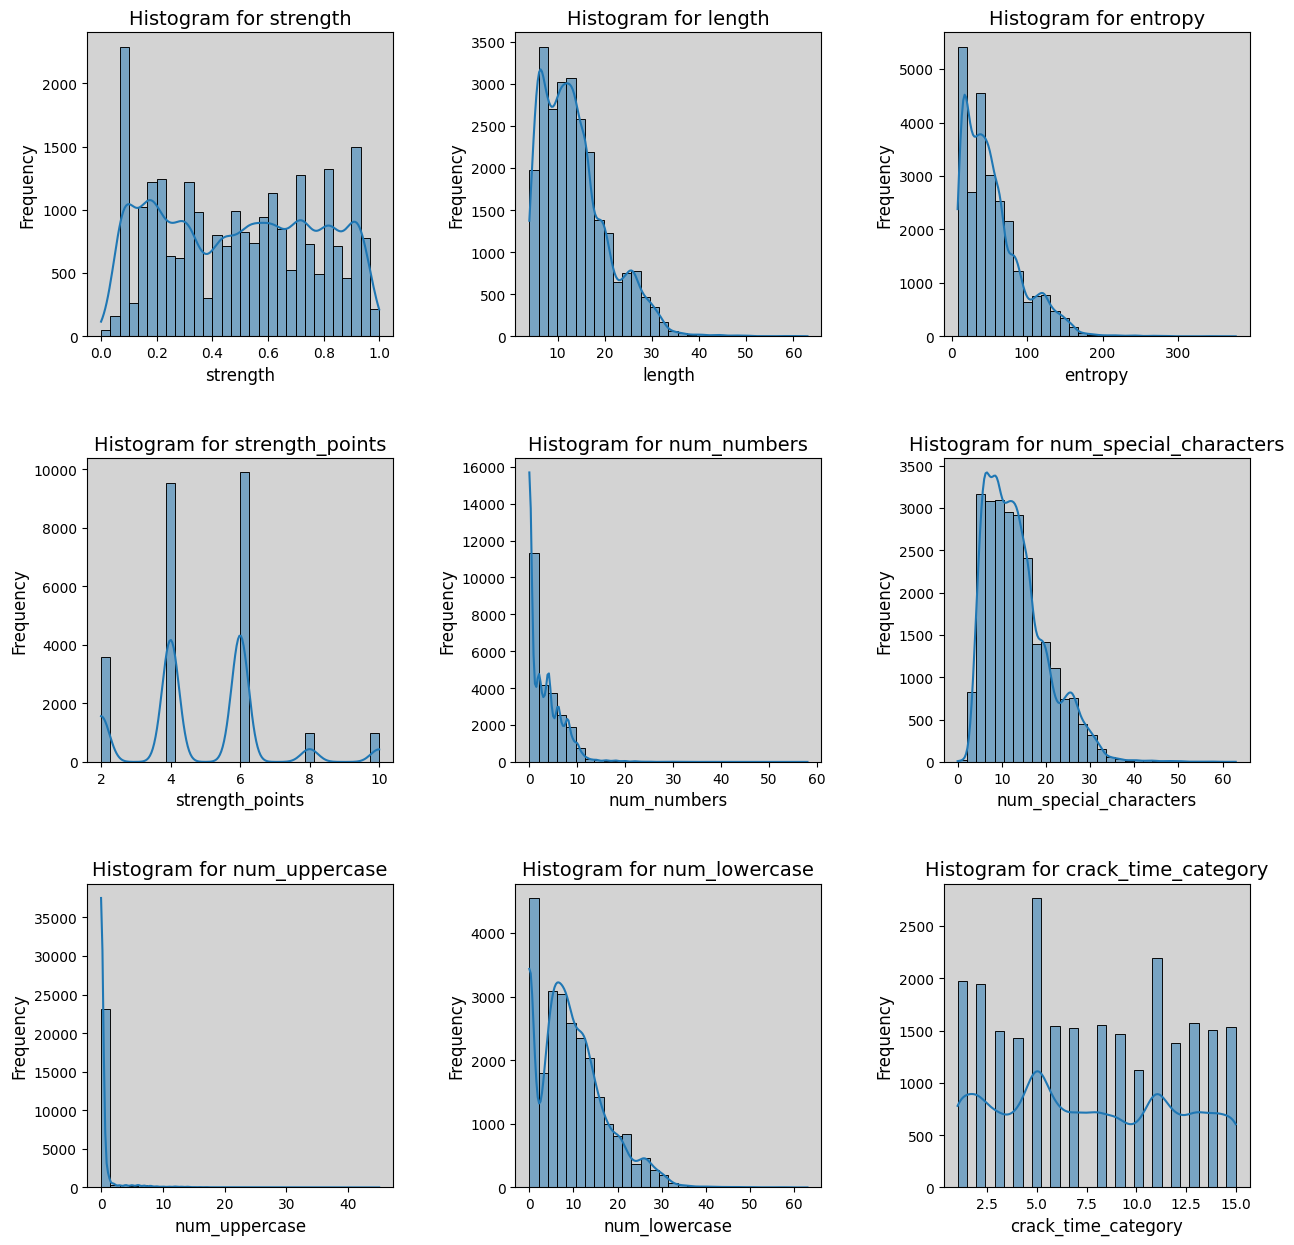

In [22]:
# Set the figure size
plt.figure(figsize=(15, 15))

# Set the background color to a custom color (e.g., light gray)
plt.rcParams['axes.facecolor'] = 'lightgray'

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot a histogram for each numerical column using histplot
numerical_cols = df.select_dtypes(include=['float64', 'int']).columns

# Iterate through numerical columns
for i, col in enumerate(numerical_cols, 1):
    # Create a subplot for each column in a 3x3 grid
    plt.subplot(3, 3, i)

    # Plot a histogram with specified number of bins and density distribution
    sns.histplot(data=df, x=col, bins=30, kde=True)

    # Set the plot title
    plt.title(f'Histogram for {col}', fontsize=14)

    # Label the x-axis
    plt.xlabel(col, fontsize=12)

    # Label the y-axis
    plt.ylabel('Frequency', fontsize=12)

# Display the plots
plt.show()


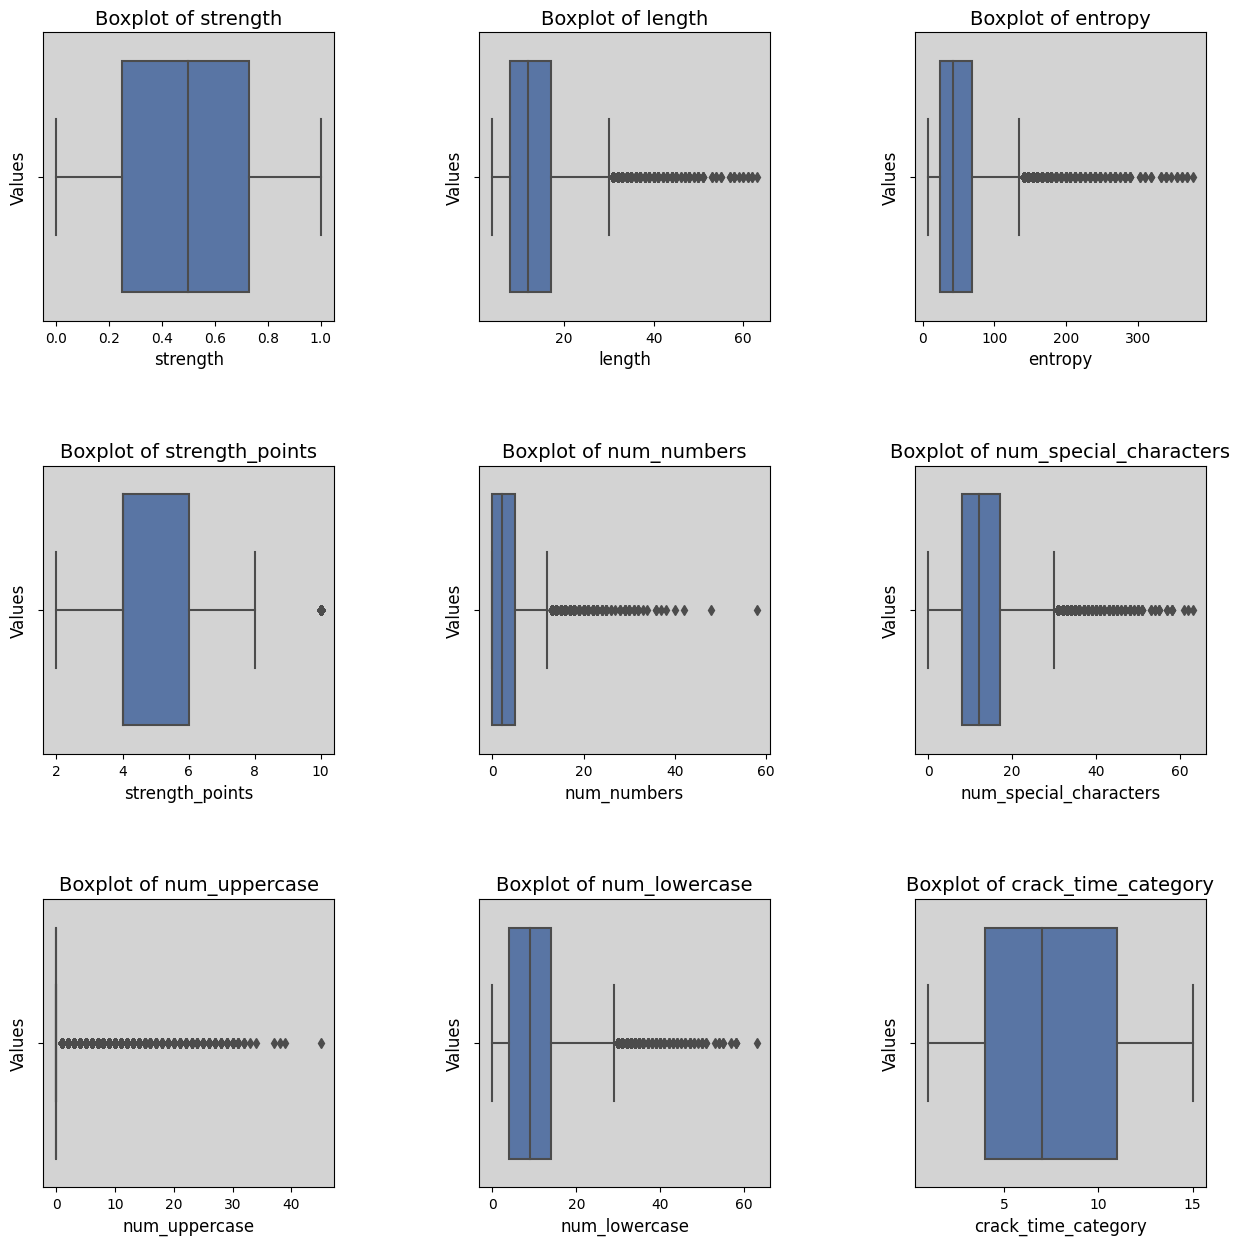

In [23]:
# Set the figure size and adjust spacing between subplots
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot a boxplot for each numerical column
numerical_cols = df.select_dtypes(include=['float64', 'int']).columns

# Define a blue color palette ('Blues' in this case)
color_palette = sns.color_palette("deep")

# Iterate through numerical columns
for i, col in enumerate(numerical_cols, 1):
    # Create a subplot for each column in a 3x3 grid
    plt.subplot(3, 3, i)

    # Create a boxplot for the current column with the blue color palette
    sns.boxplot(x=df[col], palette=color_palette)

    # Set labels and title for the subplot
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title(f'Boxplot of {col}', fontsize=14)

# Display the boxplots
plt.show()


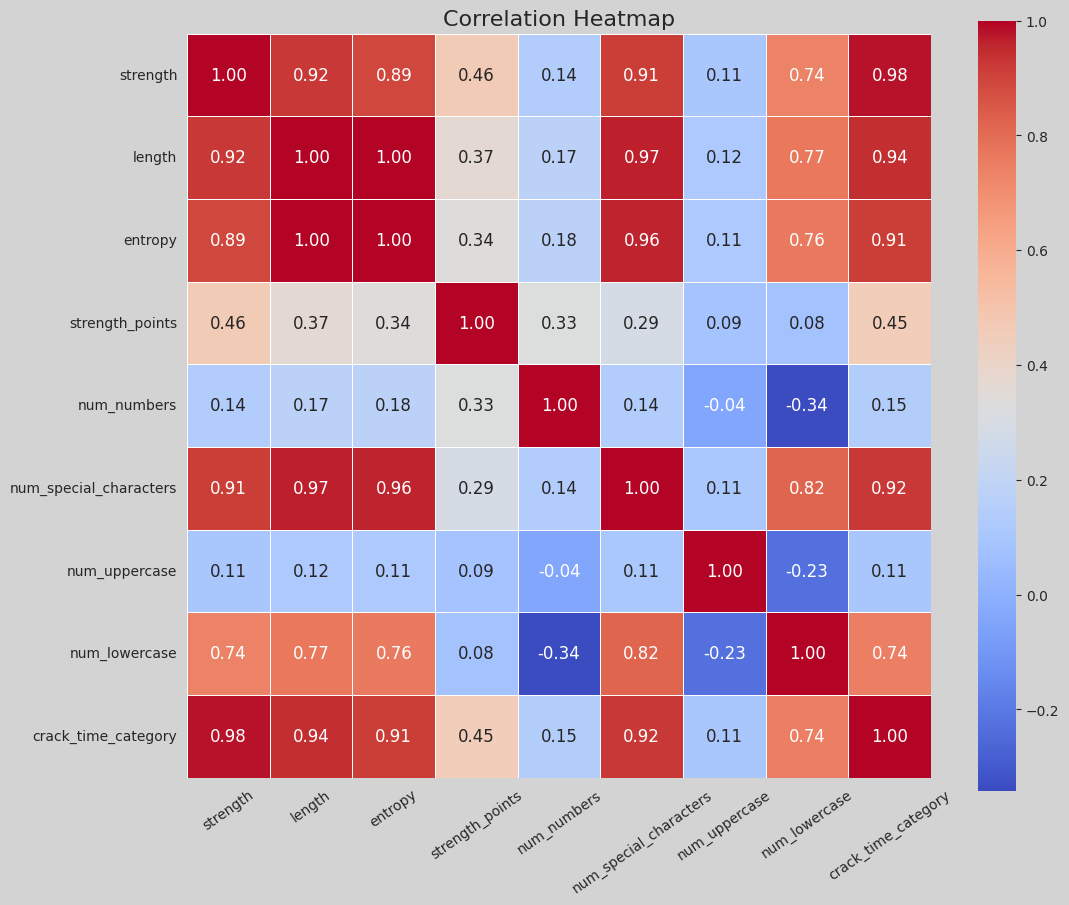

In [24]:
# Set a custom color palette with more contrast
custom_palette = sns.color_palette("coolwarm", as_cmap=True)

# Set a custom style
sns.set_style("whitegrid")

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10), facecolor='lightgray')  # Set background color to light gray

# Calculate the correlation matrix for the DataFrame
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap with annotations using seaborn
sns.heatmap(
    correlation_matrix,
    annot=True,            # Show values in each cell
    cmap=custom_palette,   # Custom color palette
    linewidths=0.5,       # Line width between cells
    square=True,           # Make the cells square
    cbar=True,             # Show the color bar
    cbar_kws={'orientation': 'vertical'},  # Customize color bar orientation
    fmt='.2f',             # Format for displaying values (2 decimal places)
    annot_kws={"size": 12},  # Adjust font size for annotations
    xticklabels=True,      # Show x-axis labels
    yticklabels=True,      # Show y-axis labels
)

# Set the title of the heatmap
plt.title("Correlation Heatmap", fontsize=16)

# Rotate the x-axis and y-axis labels for better readability
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Add more space at the top and bottom of the heatmap
plt.subplots_adjust(top=0.92, bottom=0.15)

# Display the heatmap
plt.show()


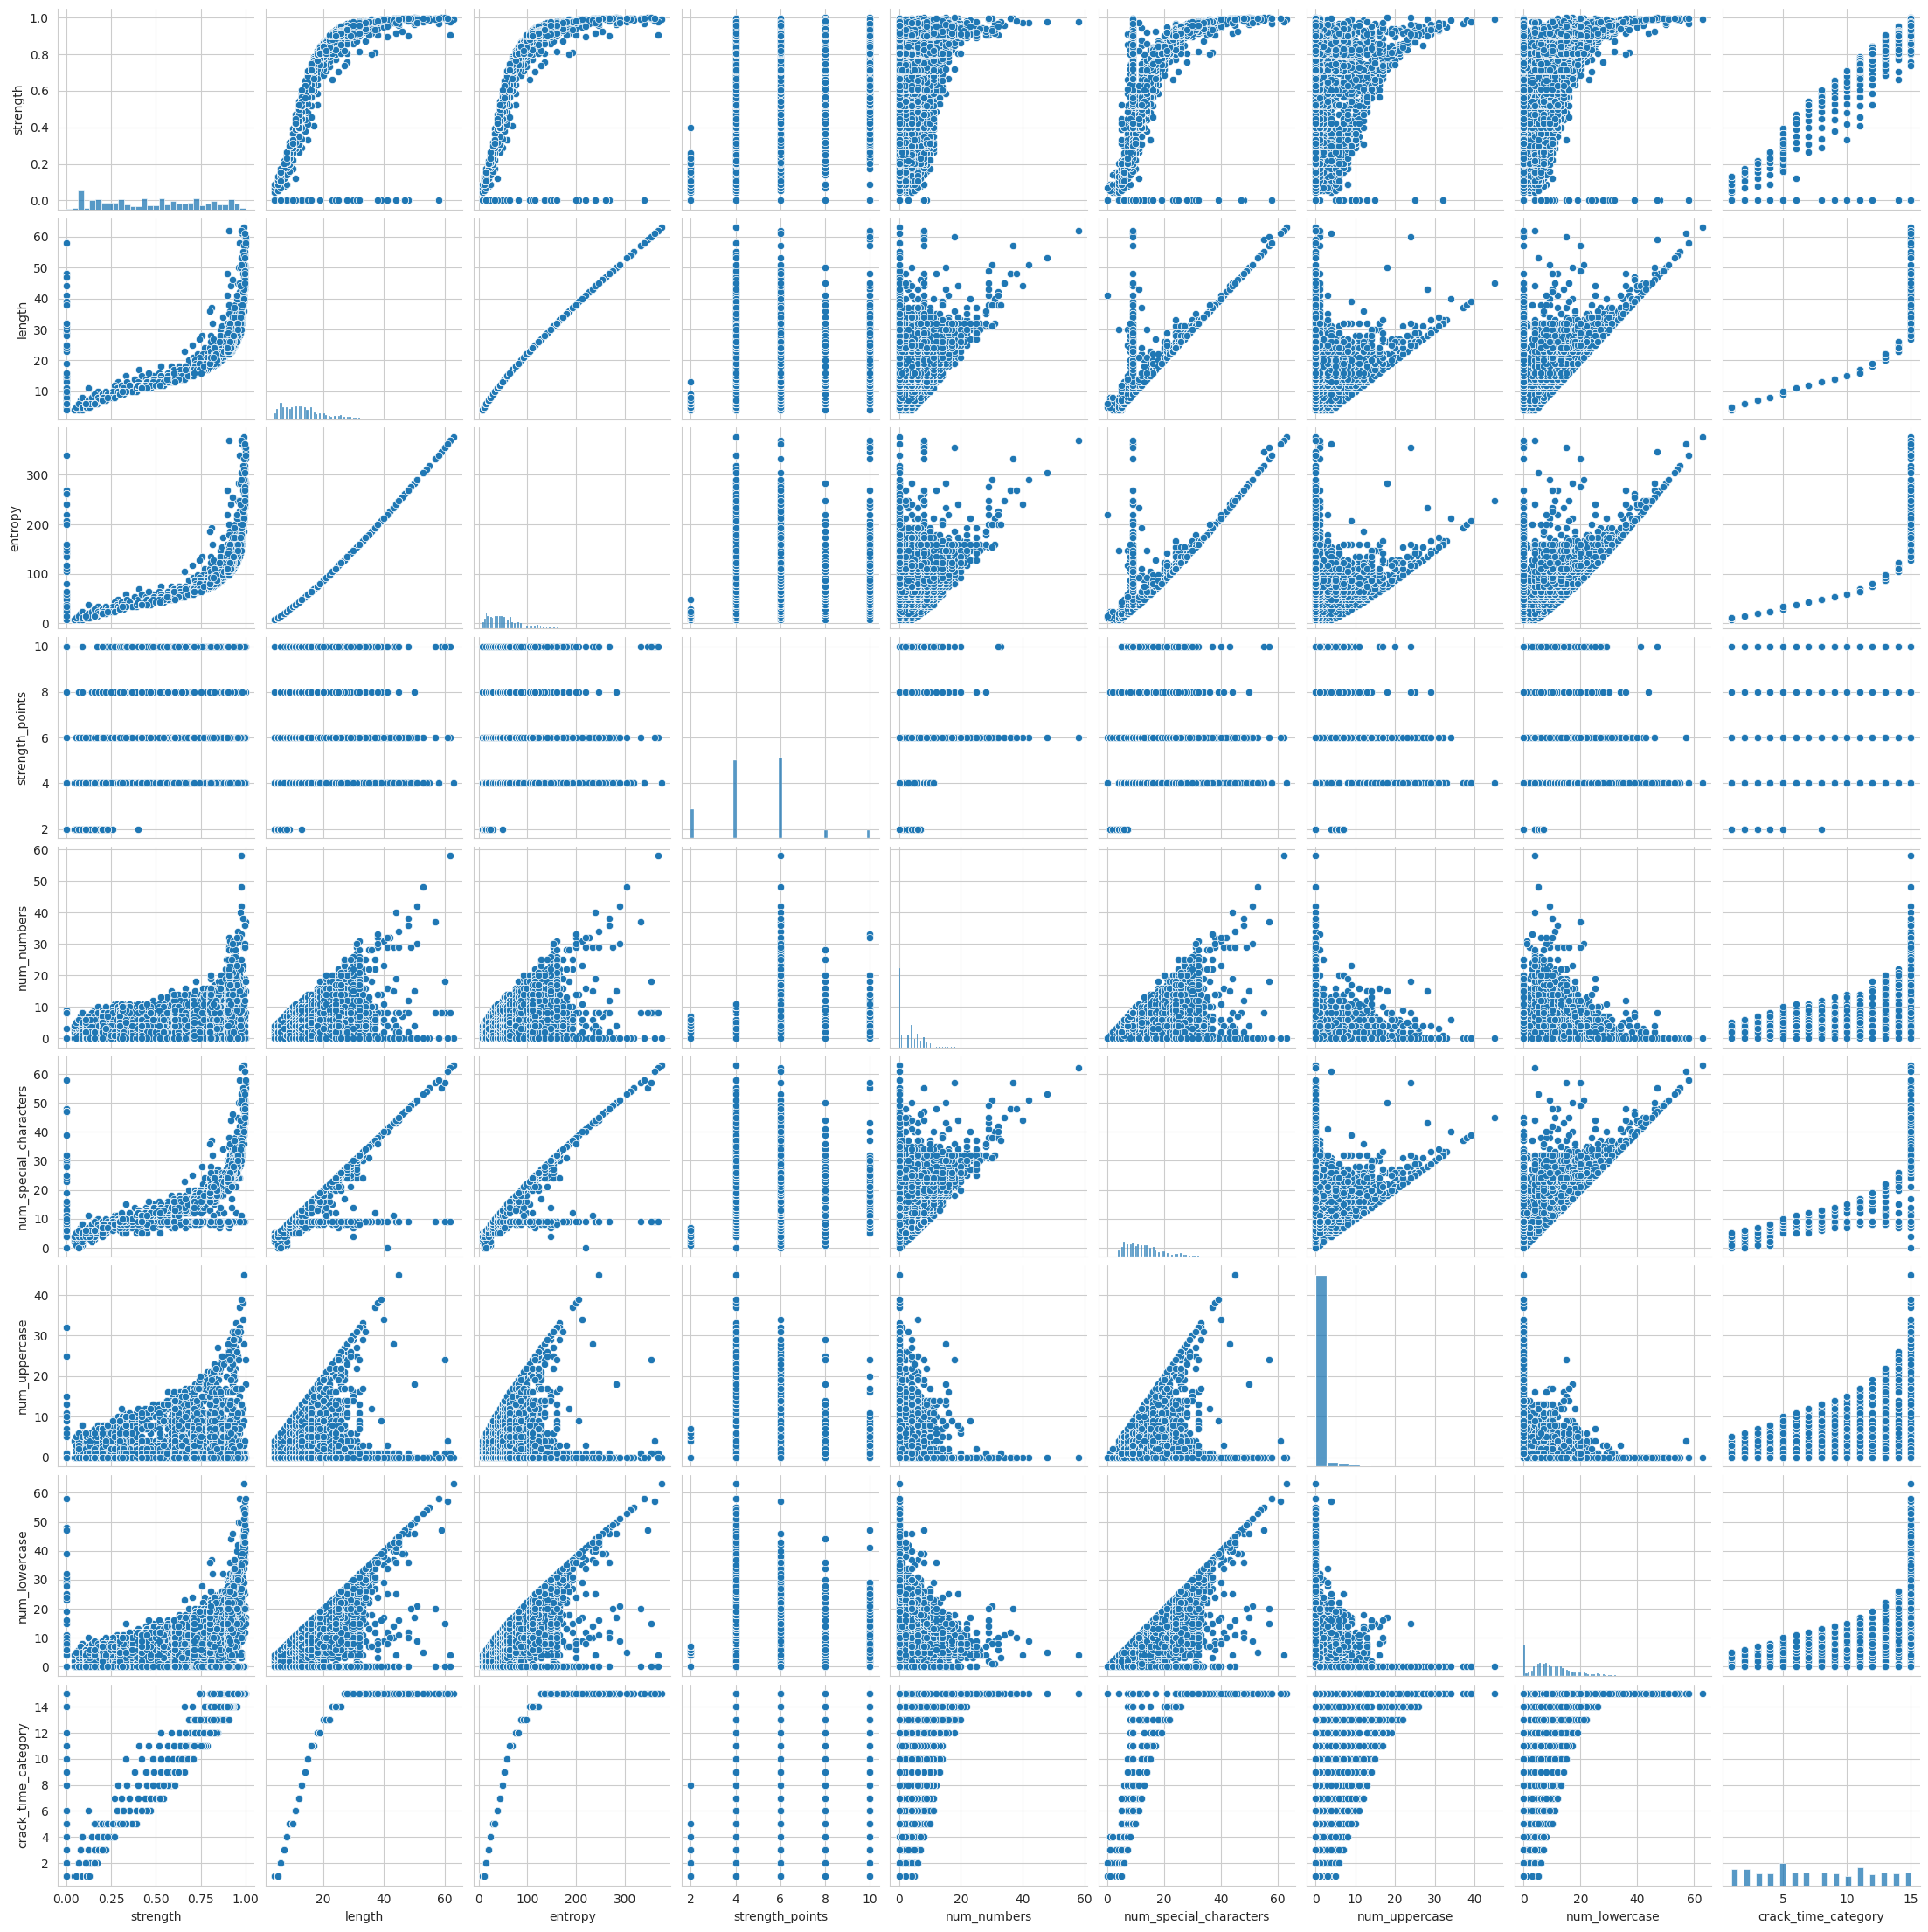

In [25]:
# Define a custom color palette
custom_palette = "husl"

# Create a pairplot and set the palette inside plot_kws
sns.pairplot(df,plot_kws={"palette": custom_palette})

# Display the pairplot
plt.show()

<Figure size 1500x1500 with 0 Axes>

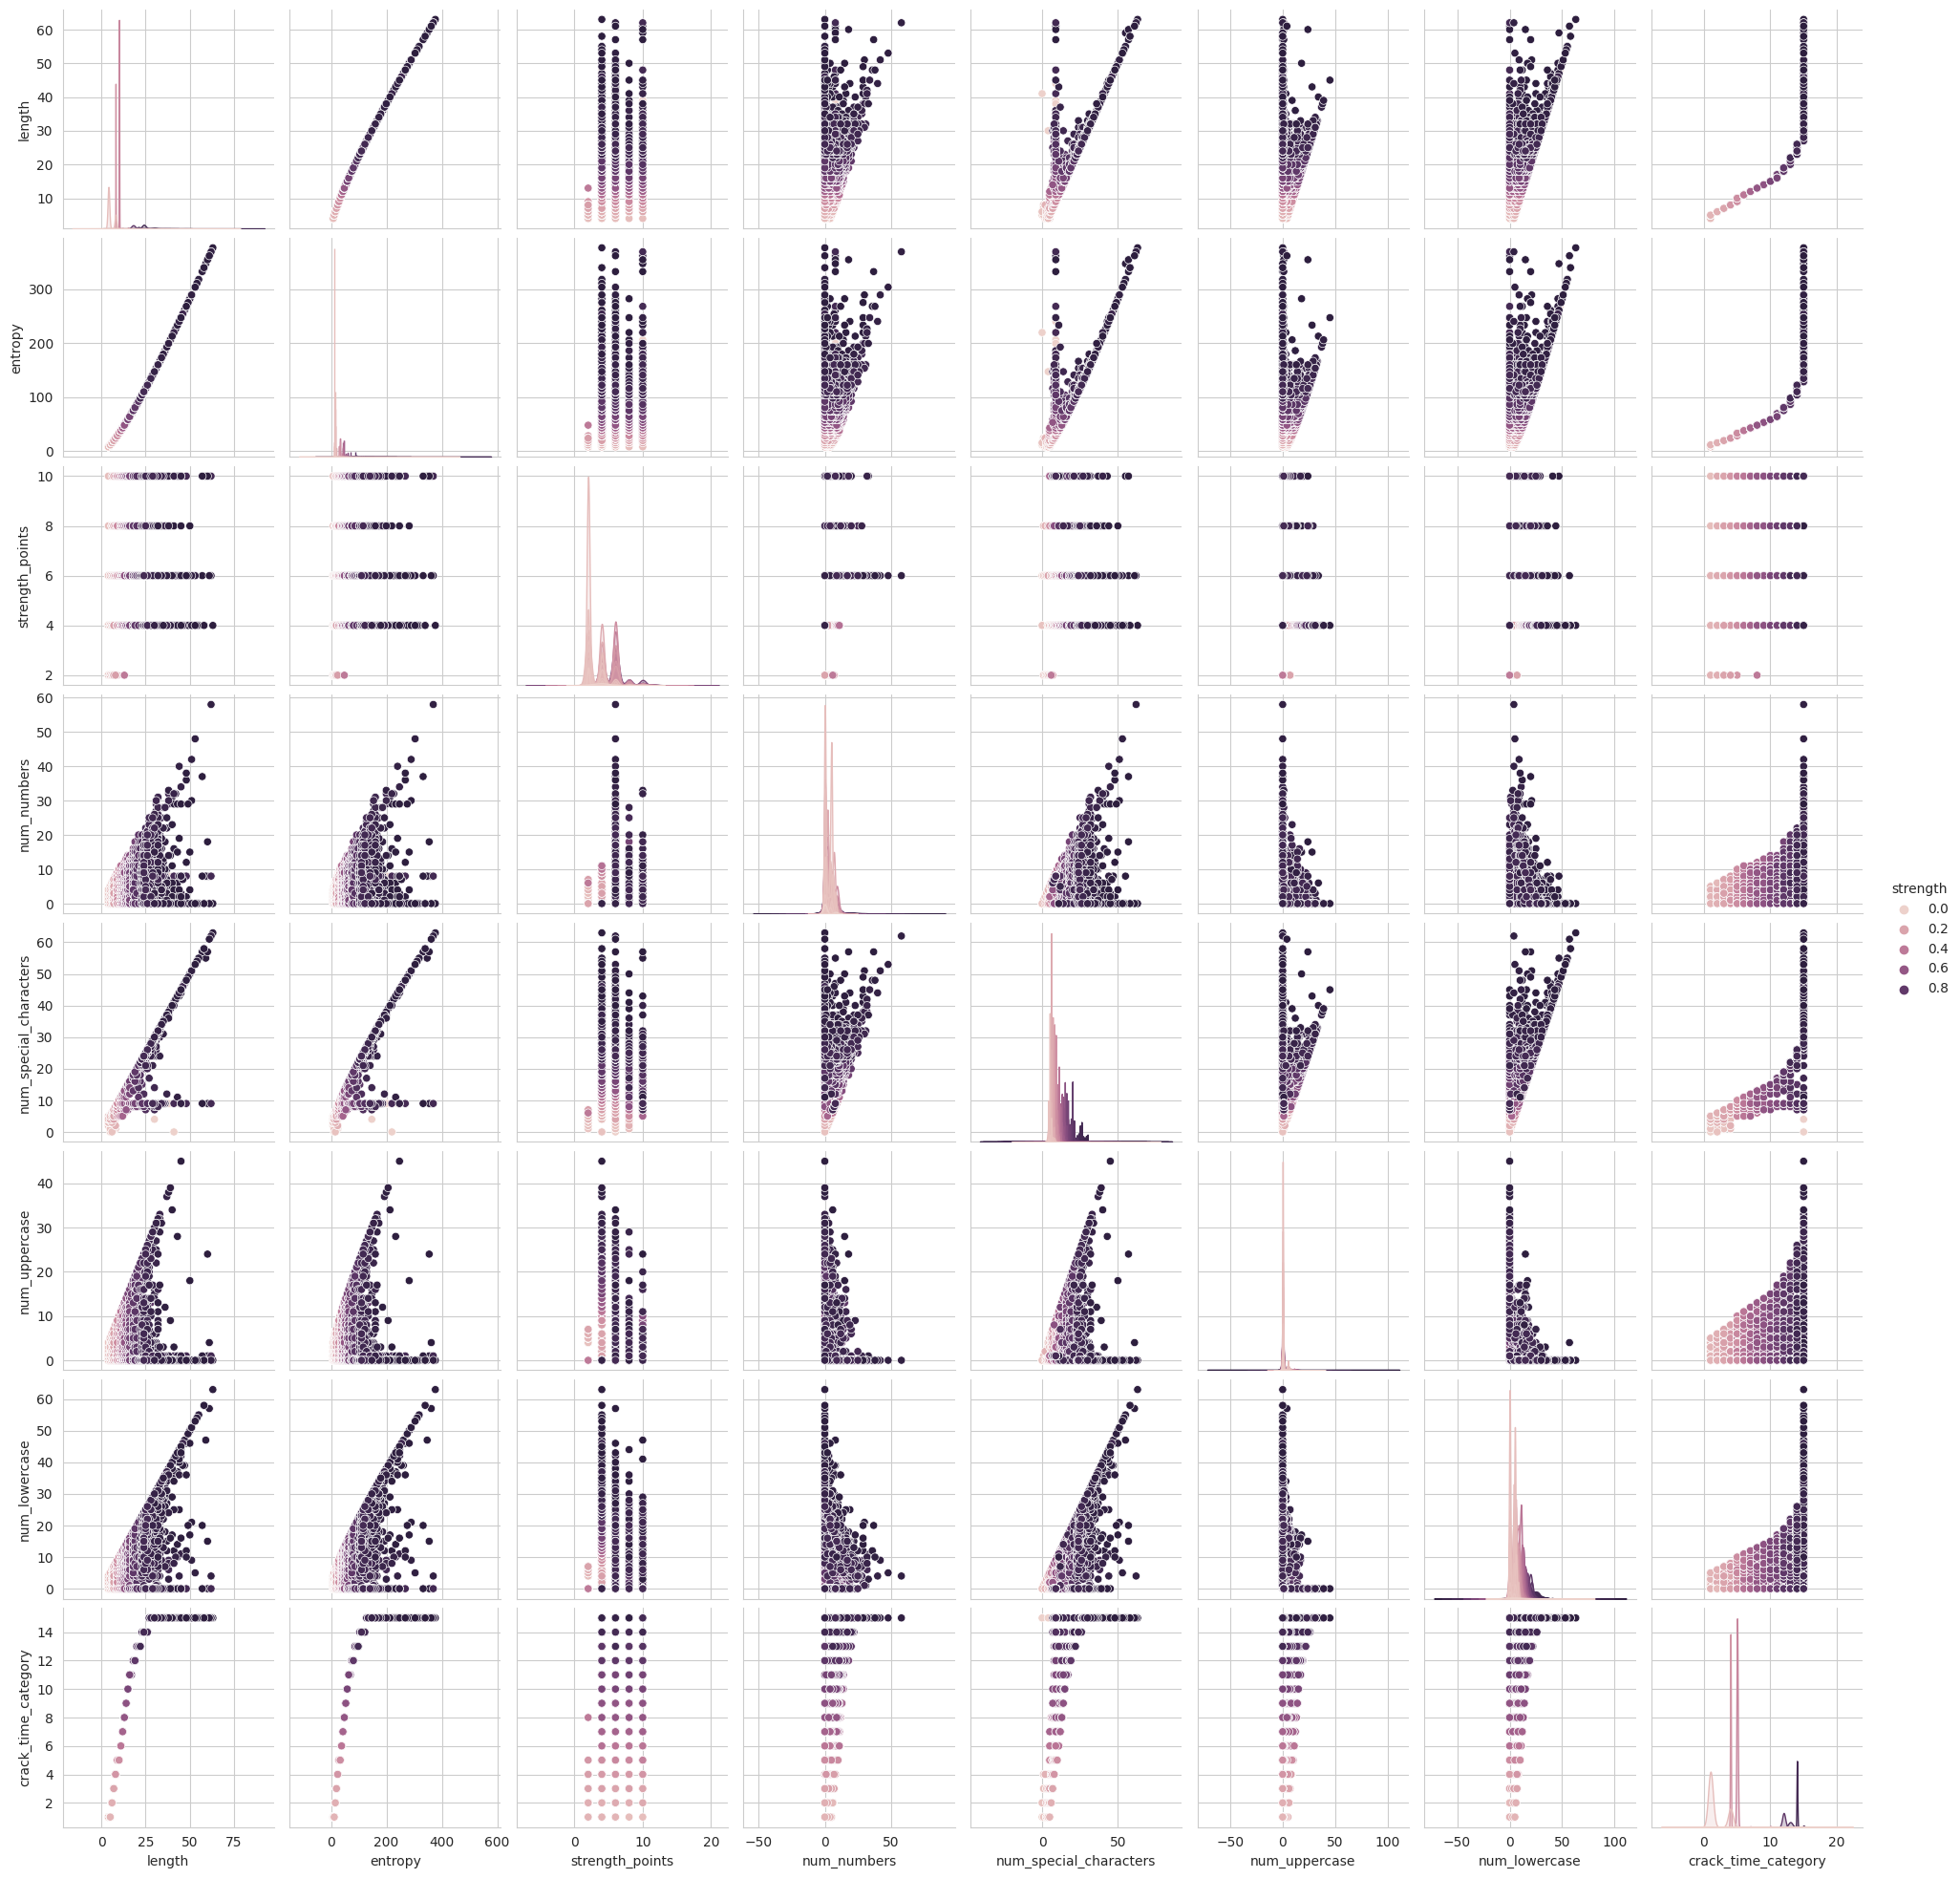

In [26]:
# Create a pairplot to visualize pairwise relationships between numerical columns
plt.figure(figsize=(15, 15))

# Use 'kde' for diagonal plots to show kernel density estimates
# Apply a custom color palette to the plot
# Assign colors to data points based on the 'strength' column
sns.pairplot(df, diag_kind='kde', plot_kws={"palette": custom_palette}, hue='strength')

# Display the pairplot
plt.show()

In [27]:
df.corr()

<ipython-input-27-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,strength,length,entropy,strength_points,num_numbers,num_special_characters,num_uppercase,num_lowercase,crack_time_category
strength,1.0000000000,0.9214797574,0.8907863137,0.4619976288,0.1400397069,0.9116949369,0.1055060558,0.7368869796,0.9828496468
length,0.9214797574,1.0000000000,0.9964666833,0.3710611324,0.1729852644,0.9667307038,0.1150326360,0.7683880385,0.9433189715
entropy,0.8907863137,0.9964666833,1.0000000000,0.3371164833,0.1760427467,0.9603737102,0.1148930586,0.7610848860,0.9142225712
strength_points,0.4619976288,0.3710611324,0.3371164833,1.0000000000,0.3258530952,0.2889888614,0.0863996742,0.0785063310,0.4530119332
num_numbers,0.1400397069,0.1729852644,0.1760427467,0.3258530952,1.0000000000,0.1381130043,-0.0440839251,-0.3414928805,0.1454007181
num_special_characters,0.9116949369,0.9667307038,0.9603737102,0.2889888614,0.1381130043,1.0000000000,0.1126877077,0.8168384122,0.9236469694
num_uppercase,0.1055060558,0.1150326360,0.1148930586,0.0863996742,-0.0440839251,0.1126877077,1.0000000000,-0.2272666730,0.1083181593
num_lowercase,0.7368869796,0.7683880385,0.7610848860,0.0785063310,-0.3414928805,0.8168384122,-0.2272666730,1.0000000000,0.7443351013
crack_time_category,0.9828496468,0.9433189715,0.9142225712,0.4530119332,0.1454007181,0.9236469694,0.1083181593,0.7443351013,1.0000000000


# TrainTheData

## One hot encoding

In [28]:
# Performing one-hot encoding to convert categorical columns into numerical ones
df_onehot = pd.get_dummies(df, columns=categorical_columns)

# Displaying the first few rows of the resulting DataFrame with one-hot encoding
df_onehot.head()

,strength,length,entropy,strength_points,num_numbers,num_special_characters,num_uppercase,num_lowercase,crack_time_category,crack_time_133.00 centuries,...,crack_time_3.00 hours,crack_time_313678.00 centuries,crack_time_4.00 centuries,crack_time_4.00 minutes,crack_time_4.00 months,crack_time_5.00 seconds,crack_time_6240.00 centuries,crack_time_8.00 years,crack_time_Eternity,crack_time_instant
0,0.0880534720,5,11.6096404700,2,0,5,0,5,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0888888890,4,8.0000000000,4,2,4,0,2,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0888888890,4,8.0000000000,2,4,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.0704427780,4,8.0000000000,2,4,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0888888890,4,8.0000000000,2,0,4,0,4,1,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
df_onehot.columns

Index(['strength', 'length', 'entropy', 'strength_points', 'num_numbers',
       'num_special_characters', 'num_uppercase', 'num_lowercase',
       'crack_time_category', 'crack_time_133.00 centuries',
       'crack_time_3.00 days', 'crack_time_3.00 hours',
       'crack_time_313678.00 centuries', 'crack_time_4.00 centuries',
       'crack_time_4.00 minutes', 'crack_time_4.00 months',
       'crack_time_5.00 seconds', 'crack_time_6240.00 centuries',
       'crack_time_8.00 years', 'crack_time_Eternity', 'crack_time_instant'],
      dtype='object')

## Scale data


In [30]:
# Multiply the 'strength' column by 100 to scale it
df_onehot['strength'] = df_onehot['strength'] * 100

In [31]:
# Separating the features (X) and the target variable (y)
X = df_onehot.drop('strength', axis=1)  # X contains all columns except 'strength'
y = df_onehot['strength']  # y contains the 'strength' column

In [32]:
# Splitting the dataset into training and testing sets
# X_train: Features for training
# X_test: Features for testing
# y_train: Target values for training
# y_test: Target values for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler

numerical_cols = X_train.select_dtypes(include=['float64','int']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the numerical columns of the training set
scaler.fit(X_train[numerical_cols])

# Transform only those columns for both the training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [34]:
X_train_scaled.head()

,length,entropy,strength_points,num_numbers,num_special_characters,num_uppercase,num_lowercase,crack_time_category,crack_time_133.00 centuries,crack_time_3.00 days,crack_time_3.00 hours,crack_time_313678.00 centuries,crack_time_4.00 centuries,crack_time_4.00 minutes,crack_time_4.00 months,crack_time_5.00 seconds,crack_time_6240.00 centuries,crack_time_8.00 years,crack_time_Eternity,crack_time_instant
18842,0.3321784964,0.2602940094,0.5950144560,0.2574087097,0.3763965335,-0.2299967298,0.3037398381,0.7592237639,0,0,0,0,1,0,0,0,0,0,0,0
13154,-0.0907614642,-0.1503447262,0.5950144560,-0.2842890129,-0.0523849371,-0.2299967298,0.1719533356,0.0692995735,0,1,0,0,0,0,0,0,0,0,0,0
2712,-0.9366413854,-0.8854775610,-1.5773778352,1.0699552938,-0.9099478785,-0.2299967298,-1.2776981923,-1.0805740772,0,0,0,0,0,0,0,0,0,0,0,1
20013,0.8960984439,0.8400082565,0.5950144560,-0.0134401516,0.9481051611,-0.2299967298,0.9626723508,1.2191732242,0,0,0,0,0,0,0,0,0,0,1,0
11013,-0.0907614642,-0.1503447262,2.7674067473,1.3408041551,-0.6240935647,0.1399634107,-1.2776981923,0.0692995735,0,1,0,0,0,0,0,0,0,0,0,0


## Linear Regression

In [35]:
# Initialize models
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 2.3857897785801727
Mean Squared Error: 15.353978537452754
Root Mean Squared Error: 3.9184153094653906
R-squared: 0.9801977112876827


## Poly Regression

In [36]:
# Create a Polynomial Regression model pipeline
poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define the hyperparameter grid
param_grid_poly = {
    'polynomialfeatures__degree': [1, 2],
    'linearregression__fit_intercept': [True, False],
}

# Create the GridSearch object
grid_search_poly = GridSearchCV(poly_model, param_grid_poly, cv=5, scoring='r2')

# Fit the model to the data
grid_search_poly.fit(X_train, y_train)

# Get the best Polynomial Regression model from the GridSearchCV
best_poly_model = grid_search_poly.best_estimator_

# Make predictions
y_pred_poly = best_poly_model.predict(X_test)

# Calculate evaluation metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Print the evaluation metrics
print("For the Best Polynomial Regression Model:")
print("Best parameters for Polynomial Regression:", grid_search_poly.best_params_)
print(f"Mean Absolute Error (MAE): {mae_poly}")
print(f"Mean Squared Error (MSE): {mse_poly}")
print(f"Root Mean Squared Error (RMSE): {rmse_poly}")
print(f"R-squared (R2): {r2_poly}")

For the Best Polynomial Regression Model:
Best parameters for Polynomial Regression: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 2}
Mean Absolute Error (MAE): 2.259497327381972
Mean Squared Error (MSE): 14.690143762695685
Root Mean Squared Error (RMSE): 3.832772333793867
R-squared (R2): 0.9810538703499708


## Decision Tree Regressor

In [37]:
# Create a DecisionTreeRegressor
dtr_model = DecisionTreeRegressor()

# Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with R-squared as the scoring metric
grid_search = GridSearchCV(dtr_model, param_grid, cv=10, scoring='r2', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

# Create a new DecisionTreeRegressor with the best hyperparameters
best_dtr_model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf)

# Fit the best model to the data (use unscaled data if it's not sensitive to scaling)
best_dtr_model.fit(X_train, y_train)

# Make predictions
y_pred = best_dtr_model.predict(X_test)

# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("For best Decision Tree Regressor :")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

For best Decision Tree Regressor :
Best max_depth: 10
Best min_samples_split: 10
Best min_samples_leaf: 4
Mean Absolute Error: 2.1489665830368407
Mean Squared Error: 13.43143781564947
Root Mean Squared Error: 3.6648926062914136
R-squared: 0.9826772449369887


In [45]:
print(df_onehot['strength'].mean())
print(max(df_onehot['strength']))
print(min(df_onehot['strength']))

49.57914975322742
99.9479781
0.0
